<a href="https://colab.research.google.com/github/HDnifq/3D_Photo_from/blob/main/SGAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SGAM: Building a Virtual 3D World through Simultaneous Generation and Mapping
[Yuan Shen<sup>1</sup>](https://yshen47.github.io/),
[Wei-Chiu Ma<sup>2</sup>](https://people.csail.mit.edu/weichium/),
[Shenlong Wang<sup>1</sup>](https://shenlong.web.illinois.edu/)<br/>
Unversity of Illinois at Urbana-Champaign<sup>1</sup>, Massachusetts Institute of Technology<sup>2</sup>
#### Accepted at NeurIPS 2022.  
[Paper link](https://nips.cc/Conferences/2022/Schedule?showEvent=55439) │ [Project Page](https://yshen47.github.io/sgam/) 


In [ ]:
!git clone https://github.com/yshen47/SGAM.git

Cloning into 'SGAM'...
remote: Enumerating objects: 317, done.
remote: Counting objects: 100% (317/317), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 317 (delta 143), reused 211 (delta 62), pack-reused 0
Receiving objects: 100% (317/317), 25.32 MiB | 10.84 MiB/s, done.
Resolving deltas: 100% (143/143), done.


In [ ]:
%cd /content/SGAM

/content/SGAM


## Download Checkpoints
If the following wget doesn't work, we provide our trained model on [GoogleEarth-Infinite](https://drive.google.com/drive/folders/1XzyLEFOWOktIgWbt3elMr5O6hbSWB7X3?usp=sharing) and [CLEVR-Infinite](https://drive.google.com/drive/folders/1AF5Q-Wq19YBAxFFjGuH6nWR-BPaKHmT7?usp=sharing):
 Upload the checkpoints to the notebook, and organize the file structure as follows:
   ```
   SGAM   
   └───trained_models
       └───google_earth
       │   │   config.yaml
       │   │   XXX.ckpt
       │    
       └───clevr-infinite   # i.e., CLEVR-Infinite
           │   config.yaml
           │   XXX.ckpt
   ```

In [ ]:
c!wget https://yshen47.web.illinois.edu/sgam/trained_models/clevr-infinite/last.ckpt -P trained_models/clevr-infinite

--2022-10-26 16:14:56--  https://yshen47.web.illinois.edu/sgam/trained_models/google_earth/N-Step-Checkpoint_2_70000.ckpt
Resolving yshen47.web.illinois.edu (yshen47.web.illinois.edu)... 18.220.149.166
Connecting to yshen47.web.illinois.edu (yshen47.web.illinois.edu)|18.220.149.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 648982627 (619M)
Saving to: ‘trained_models/google_earth/N-Step-Checkpoint_2_70000.ckpt’

N-Step-Checkpoint_2 100%[===================>] 618.92M  12.2MB/s    in 52s     

2022-10-26 16:15:50 (11.8 MB/s) - ‘trained_models/google_earth/N-Step-Checkpoint_2_70000.ckpt’ saved [648982627/648982627]

--2022-10-26 16:15:50--  https://yshen47.web.illinois.edu/sgam/trained_models/clevr-infinite/last.ckpt
Resolving yshen47.web.illinois.edu (yshen47.web.illinois.edu)... 18.220.149.166
Connecting to yshen47.web.illinois.edu (yshen47.web.illinois.edu)|18.220.149.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 661565411 

## Install Dependencies

In [ ]:
!pip install -r requirement.txt
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113
!pip install pytorch_lightning==1.5.10
!pip install "pillow<7" # only added due to python version 3.7 in colab. 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 53.3 MB/s 
     |████████████████████████████████| 116 kB 64.7 MB/s 
     |████████████████████████████████| 102 kB 74.3 MB/s 
     |████████████████████████████████| 1.9 MB 53.2 MB/s 
     |████████████████████████████████| 408.6 MB 31 kB/s 
     |████████████████████████████████| 108 kB 75.3 MB/s 
     |████████████████████████████████| 115 kB 73.8 MB/s 
     |████████████████████████████████| 109 kB 67.5 MB/s 
     |████████████████████████████████| 1.1 MB 62.7 MB/s 
     |████████████████████████████████| 8.8 MB 52.6 MB/s 
     |████████████████████████████████| 3.1 MB 59.3 MB/s 
     |████████████████████████████████| 423 kB 71.9 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 9.8 MB 65.6 MB/s 
     |████████████████████████████████| 346 kB 62.6 MB/s 
     |██████████████████████████

### (Make sure you click on RESTART RUNTIME button in the block above after the installment)

In [ ]:
%cd /content/SGAM

/content/SGAM


## Inference on GoogleEarth-Infinite dataset

In [ ]:
seed_index = 0 # Feel free to change it from 0 to 4

### 1. Visualize initial RGB-D image

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import cv2
import numpy as np
import imageio

In [ ]:
rgbd_path = Path(f'templates/google_earth/seed{seed_index}')
initial_rgb = Image.open(str(rgbd_path / 'im_00000.png'))
depth_map = np.load(str(rgbd_path / 'dm_00000.npy'))

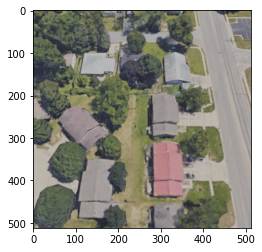

In [ ]:
plt.imshow(initial_rgb)

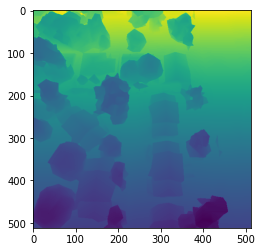

In [ ]:
plt.imshow(depth_map)

### 2. initialize model

In [ ]:
import random
import argparse
import torch
import torch.nn.functional as F
from sgam.generative_sensing_module.model import VQModel
import numpy as np
from main_scene_generation import prepare_vqgan
from sgam.inference_pipeline import InfiniteSceneGeneration

In [ ]:
google_earth_model = prepare_vqgan('google_earth').to('cuda:0').eval() 
sgam = InfiniteSceneGeneration(dynamic_model=google_earth_model,  
                               data='google_earth', 
                               seed_index=seed_index,
                                use_rgbd_integration=True,
                                offscreen_rendering=True, # This has to be True in the colab environment unless you install in your local environment. If False, a graphic interface will be visible to show the gobal mapping
                              ) 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

loaded pretrained LPIPS loss from sgam/generative_sensing_module/modules/autoencoder/lpips/vgg.pth
Working with z of shape (1, 256, 4, 4) = 4096 dimensions.
loaded pretrained LPIPS loss from sgam/generative_sensing_module/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from trained_models/google_earth/N-Step-Checkpoint_2_70000.ckpt


### 2. One-step prediction 

Check InfiniteSceneGeneration.one_step_prediction function in sgam/inference_pipeline.py for complete function

#### a. visualize source RGB-D poses



In [ ]:
tgt_pose_grid_coord = sgam.next_pose(sgam.curr)
src_pose_grid_coords, _ = sgam.get_src_grid_coords(tgt_pose_grid_coord)
tgt_meta = sgam.transform_grid[tgt_pose_grid_coord[0]][tgt_pose_grid_coord[1]]
src_metas = [sgam.transform_grid[src_pose_grid_coord[0]][src_pose_grid_coord[1]] for src_pose_grid_coord in src_pose_grid_coords]

In [ ]:
src_metas

[{'R': array([[ 1.        ,  0.        ,  0.        ],
         [-0.        , -0.86602526, -0.50000024],
         [-0.        ,  0.50000024, -0.86602526]]),
  't': array([ 3.        , -4.19615111,  4.73205194]),
  'K': array([[248.88887,   0.     , 128.     ],
         [  0.     , 248.88887, 128.     ],
         [  0.     ,   0.     ,   1.     ]]),
  'position': array([-3.        , -5.99999995,  1.99999998]),
  'rgb_path': 'grid_res/google_earth_seed0/im_00000_00_00.png',
  'depth_path': 'grid_res/google_earth_seed0/dm_00000_00_00.npy',
  'R_path': 'grid_res/google_earth_seed0/R_00000.npy',
  'K_path': 'grid_res/google_earth_seed0/K_00000.npy',
  't_path': 'grid_res/google_earth_seed0/t_00000.npy',
  'visited': True,
  'grid_coord': (0, 0)}]

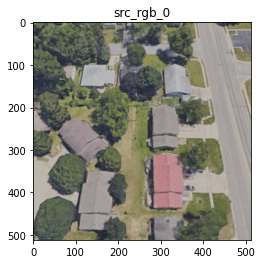

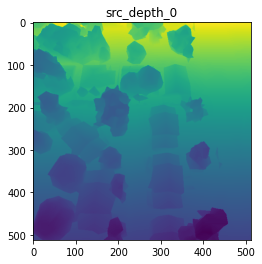

In [ ]:
for src_i, src_meta in enumerate(src_metas):
    initial_rgb = Image.open(src_meta['rgb_path'])
    depth_map = np.load(src_meta['depth_path'])
    plt.figure()
    plt.title(f"src_rgb_{src_i}")
    plt.imshow(initial_rgb)

    plt.figure()
    plt.title(f"src_depth_{src_i}")
    plt.imshow(depth_map)

#### b. warp source to target poses

In [ ]:
# prepare inputs
img_srcs = [np.array(Image.open(src_node['rgb_path']).resize((sgam.image_resolution[1], sgam.image_resolution[0]), resample=Image.LANCZOS)) / 127.5 - 1.0 for src_node in src_metas]
img_dst = np.zeros_like(img_srcs[0])    # placeholder
dm_srcs = [F.interpolate(torch.from_numpy(np.load(src_node['depth_path'])[None, None,]), size=sgam.image_resolution)[0][
    0].numpy().squeeze() for src_node in src_metas]
dm_dst = np.zeros_like(dm_srcs[0])      # placeholder
print([src_node['depth_path'] for src_node in src_metas])

R_dst = tgt_meta["R"]
t_dst = tgt_meta["t"]

R_rels = []
t_rels = []
Ks = []
K_invs = []
T_tgt = np.eye(4)
T_tgt[:3, :3] = R_dst
T_tgt[:3, 3] = t_dst

K = sgam.K
Rs = [src_node["R"] for src_node in src_metas]
ts = [src_node["t"] for src_node in src_metas]
T_tgt2srcs = []
for src_node in src_metas:
    R_src = src_node["R"]
    t_src = src_node["t"]
    T_src = np.eye(4)
    T_src[:3, :3] = R_src
    T_src[:3, 3] = t_src
    T_rel = T_tgt @ np.linalg.inv(T_src)
    T_tgt2srcs.append(np.linalg.inv(T_rel))
    R_rel = T_rel[:3, :3]
    t_rel = T_rel[:3, 3]
    R_rels.append(R_rel)
    t_rels.append(t_rel)
    Ks.append(K)
    K_invs.append(np.linalg.inv(K))

['grid_res/google_earth_seed0/dm_00000_00_00.npy']


##### Get target depth with RGB-D Integrated mapping, and then sample colors from source views using inverse warping

In [ ]:
integrated_tgt_depth = sgam.rgbd_integration(Ks, Rs, ts,
                                          dm_srcs,
                                          [src_node['rgb_path'] for src_node in src_metas],
                                          K, T_tgt)

warped_features = sgam.inverse_warping(torch.tensor(img_srcs).permute(0, 3, 1, 2)[None,].float().cuda(),
                                      torch.tensor(dm_srcs)[None,].float().cuda(),
                                      torch.from_numpy(integrated_tgt_depth)[None,].float().cuda(),
                                      torch.tensor(Ks)[None,].float().cuda(),
                                      torch.from_numpy(K)[None,].float().cuda(),
                                      torch.tensor(T_tgt2srcs)[None,].float().cuda())

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


[Open3D INFO] EGL headless mode enabled.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


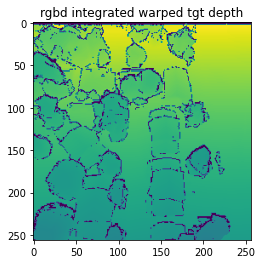

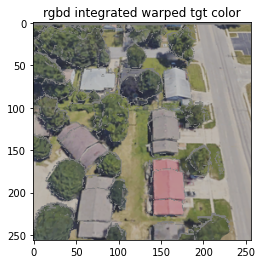

In [ ]:
plt.imshow(integrated_tgt_depth)
plt.title("rgbd integrated warped tgt depth")
plt.show()

plt.imshow((warped_features.transpose(1,2,0) + 1)/2)
plt.title("rgbd integrated warped tgt color")
plt.show()

In [ ]:
# prepare batch data
for i, dm_src in enumerate(dm_srcs):
    curr_index = int(src_metas[i]['rgb_path'].split('/')[-1][3:-4])
    if curr_index == 0 and sgam.data == 'clevr-infinite':
        h, w = dm_src.shape[:2]
        x = np.linspace(0, w - 1, w)
        y = np.linspace(0, h - 1, h)
        xs, ys = np.meshgrid(x, y)
        dm_srcs[i] = (dm_srcs[i] * sgam.K[0][0] / np.sqrt(
            sgam.K[0][0] ** 2 + (sgam.K[0][2] - ys - 0.5) ** 2 + (sgam.K[1][2] - xs - 0.5) ** 2)) # convert nonlinear depth (raw from blender) to linear

batch = {
    "Ks": np.stack(Ks)[None, ],
    "K_invs": np.stack(K_invs)[None, ],
    "R_rels": np.stack(R_rels)[None, ],
    "t_rels": np.stack(t_rels)[None, ],
    "dst_img": img_dst[None, ],
    "src_imgs": np.stack(img_srcs)[None, ],
    "dst_depth": dm_dst[None, ],
    "src_depths": np.stack(dm_srcs)[None, ],
}

batch["warped_tgt_features"] = warped_features[None,]
batch["warped_tgt_depth"] = integrated_tgt_depth[None,]


for k in batch:
    batch[k] = torch.from_numpy(batch[k].astype(np.float32)).cuda()


batch['src_depths'] = batch['src_depths'][..., None]
x, x_dst, extrapolation_mask, warped_depth = sgam.dynamic_model.get_x(batch, sgam.data,
                                                                    return_extrapolation_mask=True,
                                                                    no_depth_range=True,
                                                                    parallel=True) # Note within this function, it will perform forward warping if target depth is not inferred from rgbd-integrated mapping. 

c. Run generative sensing model to complete partial and noisy observation

In [ ]:
rgbd_prediction= sgam.dynamic_model(x, topk=sgam.topk,
                                      extrapolation_mask=extrapolation_mask,
                                      get_pre_quantized_feature=False,
                                      get_quantized_feature=False,
                                      sample_number=1)[0][0][0][0]

d. Post-process predictions and visualize results

In [ ]:
predicted_rgb = np.clip(((rgbd_prediction[:3] + 1) / 2 * 255.).permute(1, 2, 0).detach().cpu().numpy(), 0,
                          255).astype(np.uint8)

predicted_depth = (1 / ((rgbd_prediction[3] + 1) / 2 * (1 / 10.099975586 - 1 / 14.765625) + 1 / 14.765625) - 10).detach().cpu().numpy()

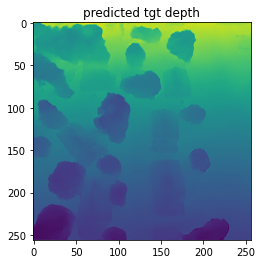

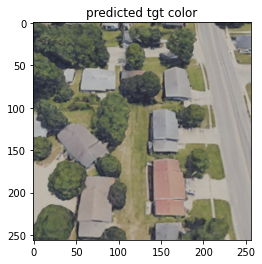

In [ ]:
plt.imshow(predicted_depth)
plt.title("predicted tgt depth")
plt.show()

plt.imshow(predicted_rgb)
plt.title("predicted tgt color")
plt.show()

### 3. Complete scene expansion with multiple SGAM iterations.

Results are stored in grid_res/google_earth_seed[seed_index] folder. rgb-d integrated mesh is available at the above directory too.

In [ ]:
# Recommend checking the initalizer of InfiniteSceneGeneration, to explore how different trajectory shape, step_size, and RGB-D SDF truncated value influence prediction. 
sgam = InfiniteSceneGeneration(dynamic_model=google_earth_model,  
                               data='google_earth', 
                               seed_index=seed_index,
                                use_rgbd_integration=True,
                                offscreen_rendering=True, # This has to be True in the colab environment unless you install in your local environment. If False, a graphic interface will be visible to show the gobal mapping
                                output_dim=(50, 1), # output_dim defines target trajectory grid dimension, (height, width). Feel free to increase length
                                num_src=3, # maximum number of source poses to sample when there are more than num_src nearby source available. The higher num_src is, the more consistent the target pose will be.
                               ) 
sgam.scene_expansion()

### 4. Generate and visualize GIF 

In [ ]:
images = []
gif_path = f'grid_res/google_earth_seed{seed_index}/animated.gif'
for filename in sorted(Path(f'grid_res/google_earth_seed{seed_index}').glob('im*')):
    images.append(imageio.imread(filename))
imageio.mimsave(gif_path, images)

In [ ]:
from IPython.display import Image
Image(open(gif_path,'rb').read())

#### 5. Visualize RGB-D integrated point cloud

In [ ]:
import plotly.graph_objects as go
import open3d as o3d

mesh_path = f'grid_res/google_earth_seed{seed_index}/rgbd_integrated_mesh.ply'
rgbd_integrated_ply = o3d.io.read_point_cloud(mesh_path)
downpcd = rgbd_integrated_ply.voxel_down_sample(voxel_size=0.02)
points = np.asarray(downpcd.points)
colors = np.asarray(downpcd.colors)

In [ ]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=-points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.update_layout(scene_aspectmode='data')
fig.show()

### 5. Command line Example 

Results are stored in grid_res/google_earth_seed[seed_index] folder. rgb-d integrated mesh is available at the above directory too.

In [ ]:
!python main_scene_generation.py --dataset='google_earth' --use_rgbd_integration True --seed_index=1

INFO - 2022-10-24 19:55:34,243 - instantiator - Created a temporary directory at /tmp/tmphkedtai2
INFO - 2022-10-24 19:55:34,244 - instantiator - Writing /tmp/tmphkedtai2/_remote_module_non_scriptable.py
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
loaded pretrained LPIPS loss from sgam/generative_sensing_module/modules/autoencoder/lpips/vgg.pth
Working with z

## Inference on Clevr-Infinite Dataset

Similarly, for CLEVR-Infinite, the inference can be run with the following command, and results are visualized in grid/clevr-infinite_seed[seed_index] fodler 

In [ ]:
clevr_infinite_model = prepare_vqgan('clevr-infinite').to('cuda:0').eval() 
# Recommend checking the initalizer of InfiniteSceneGeneration, to explore how different trajectory shape, step_size, and RGB-D SDF truncated value influence prediction. 
sgam = InfiniteSceneGeneration(dynamic_model=clevr_infinite_model,  
                               data='clevr-infinite', 
                               seed_index=seed_index,
                                use_rgbd_integration=True,
                                offscreen_rendering=True, # This has to be True in the colab environment unless you install in your local environment. If False, a graphic interface will be visible to show the gobal mapping
                                output_dim=(10, 10), # output_dim defines target trajectory grid dimension, (height, width). Feel free to increase length
                                num_src=3, # maximum number of source poses to sample when there are more than num_src nearby source available. The higher num_src is, the more consistent the target pose will be.
                               ) 
sgam.scene_expansion()

In [ ]:
images = []
gif_path = f'grid_res/clevr-infinite_seed{seed_index}/animated.gif'
for filename in sorted(Path(f'grid_res/clevr-infinite_seed{seed_index}').glob('im*')):
    images.append(imageio.imread(filename))
imageio.mimsave(gif_path, images)
Image(open(gif_path,'rb').read())

In [ ]:
# visualize rgb-d integrated point cloud

mesh_path = f'grid_res/clevr-infinite_seed{seed_index}/rgbd_integrated_mesh.ply'
rgbd_integrated_ply = o3d.io.read_point_cloud(mesh_path)
downpcd = rgbd_integrated_ply.voxel_down_sample(voxel_size=0.02)
points = np.asarray(downpcd.points)
colors = np.asarray(downpcd.colors)
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=-points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.update_layout(scene_aspectmode='data')
fig.show()

In [ ]:
!python main_scene_generation.py --dataset='clevr-infinite' --use_rgbd_integration True